## Time_Series_&_Stock_Market_forcasting





In [1]:
# basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns

from sklearn.metrics import mean_squared_error

import warnings, os, math, itertools
warnings.filterwarnings("ignore")



## Load Dataset

In [2]:

file_path ="D:\project complete\sample_stock_10000.csv"
df = pd.read_csv(file_path)


print(df.shape)
df.head()
df.info()
df.drop_duplicates()

(10000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10000 non-null  object 
 1   Open       10000 non-null  float64
 2   High       10000 non-null  float64
 3   Low        10000 non-null  float64
 4   Close      10000 non-null  float64
 5   Adj Close  10000 non-null  float64
 6   Volume     10000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 547.0+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-01,100.391688,100.598129,99.994022,100.528104,100.528104,128549
1,2010-01-04,100.357970,100.476229,100.146218,100.419327,100.419327,270046
2,2010-01-05,100.981375,101.291536,100.862817,101.102168,101.102168,147400
3,2010-01-06,102.707247,102.826302,102.653833,102.684571,102.684571,170294
4,2010-01-07,102.720513,103.026637,102.265248,102.475150,102.475150,232977
...,...,...,...,...,...,...,...
9995,2048-04-24,1647.117846,1649.019569,1642.155706,1645.841242,1645.841242,167443
9996,2048-04-27,1618.207642,1622.882981,1612.906754,1613.762158,1613.762158,160739
9997,2048-04-28,1604.113795,1605.722296,1600.924487,1602.900868,1602.900868,208990
9998,2048-04-29,1616.872756,1622.992156,1608.725274,1611.350562,1611.350562,185833


## Preprocess Data

In [3]:
# Convert date

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Missing values
print("Missing values:\n", df.isna().sum())
df = df.dropna()

# Outliers (z-score filter for Close)
from scipy import stats
df = df[(np.abs(stats.zscore(df['Close'])) < 3)]

# Resample daily (if multiple per day)
df = df.resample('D').ffill()

print("Final shape:", df.shape)



Missing values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Final shape: (14000, 6)


## EDA(Exploratory Data Analysis)

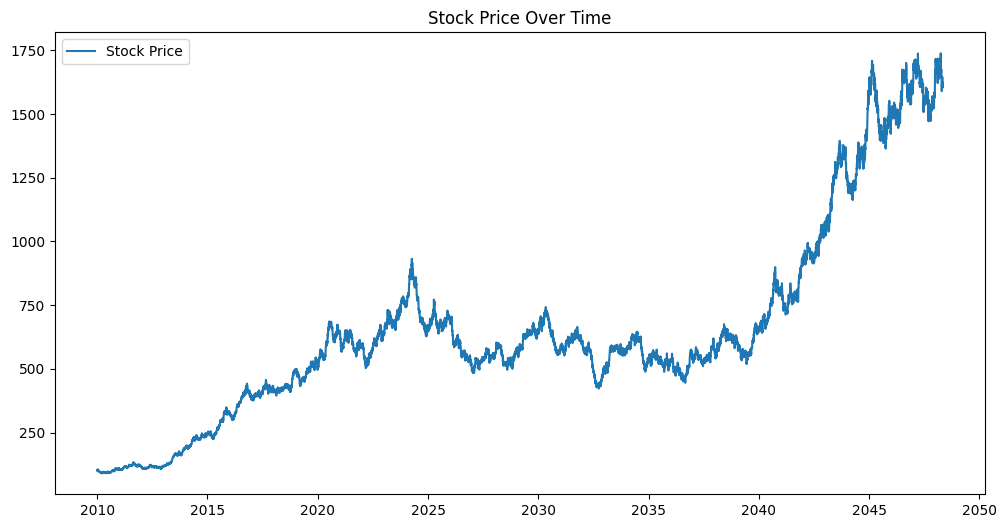

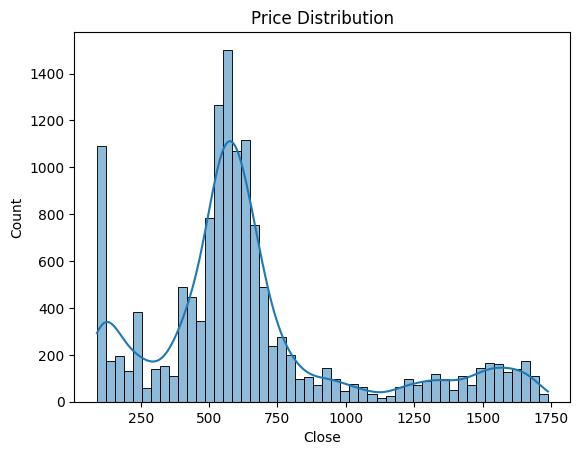

count    14000.000000
mean       649.334472
std        382.293411
min         90.103051
25%        466.065599
50%        578.286764
75%        700.794195
max       1738.623979
Name: Close, dtype: float64


In [4]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Stock Price")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

sns.histplot(df['Close'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

print(df['Close'].describe())


## Train/ Test split + Baseline

In [5]:
train_size = int(len(df)*0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Baseline: naive forecast (last value)
naive_forecast = [train.iloc[-1]] * len(test)

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

print("Naive RMSE:", np.sqrt(mean_squared_error(test, naive_forecast)))
print("Naive MAPE:", mean_absolute_percentage_error(test, naive_forecast))


Naive RMSE: 539.7539784061667
Naive MAPE: 0.31988398573413346


## Train Models
**(a) ARIMA**

In [6]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(steps=len(test))


**(b) SARIMA**

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,12)).fit(disp=False)
sarima_forecast = sarima_model.forecast(steps=len(test))


**(c) Prophet**

In [8]:
from prophet import Prophet

prophet_df = df.reset_index()[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
train_p, test_p = prophet_df[:train_size], prophet_df[train_size:]

m = Prophet()
m.fit(train_p)

future = m.make_future_dataframe(periods=len(test_p))
forecast = m.predict(future)
prophet_forecast = forecast['yhat'][-len(test_p):].values


Importing plotly failed. Interactive plots will not work.
20:33:38 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] done processing


**(d)LSTM**

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Close']])

train_scaled, test_scaled = scaled[:train_size], scaled[train_size:]

# Create sequences
def create_seq(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 60
X_train, y_train = create_seq(train_scaled, seq_len)
X_test, y_test = create_seq(test_scaled, seq_len)

X_train = X_train.reshape(X_train.shape[0], seq_len, 1)
X_test = X_test.reshape(X_test.shape[0], seq_len, 1)

# Model
lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len,1)),
    LSTM(50),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
lstm_pred = lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - loss: 8.8847e-04
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - loss: 4.4303e-05
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - loss: 3.9039e-05
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - loss: 3.5824e-05
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - loss: 3.4282e-05
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - loss: 3.1900e-05
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - loss: 3.2175e-05
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - loss: 2.6848e-05
Epoch 9/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 31s 88ms/step - loss: 2.4513e-05
Epoch 10/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - loss: 2.3599e-05
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


## Evaluation(RMSE & MAPE)

In [10]:
def evaluate(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred)
    print(f"{name} → RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    return rmse, mape

evaluate(test, arima_forecast, "ARIMA")
evaluate(test, sarima_forecast, "SARIMA")
evaluate(test, prophet_forecast, "Prophet")
evaluate(y_test_inv, lstm_pred, "LSTM")


ARIMA → RMSE: 540.48, MAPE: 32.03%
SARIMA → RMSE: 436.19, MAPE: 25.96%
Prophet → RMSE: 619.90, MAPE: 40.75%
LSTM → RMSE: 43.46, MAPE: 3.03%


(np.float64(43.46195990682566), 0.030331601640538667)

## Backtesting(TimeSeriseSplit)

In [11]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
    train_fold, test_fold = df['Close'].iloc[train_idx], df['Close'].iloc[test_idx]
    model = ARIMA(train_fold, order=(5,1,0)).fit()
    pred = model.forecast(steps=len(test_fold))
    rmse = np.sqrt(mean_squared_error(test_fold,pred))
    print(f"Fold {fold+1} RMSE: {rmse:.2f}")


Fold 1 RMSE: 176.42
Fold 2 RMSE: 96.09
Fold 3 RMSE: 61.53
Fold 4 RMSE: 146.16
Fold 5 RMSE: 523.02


## Visualize Predictions

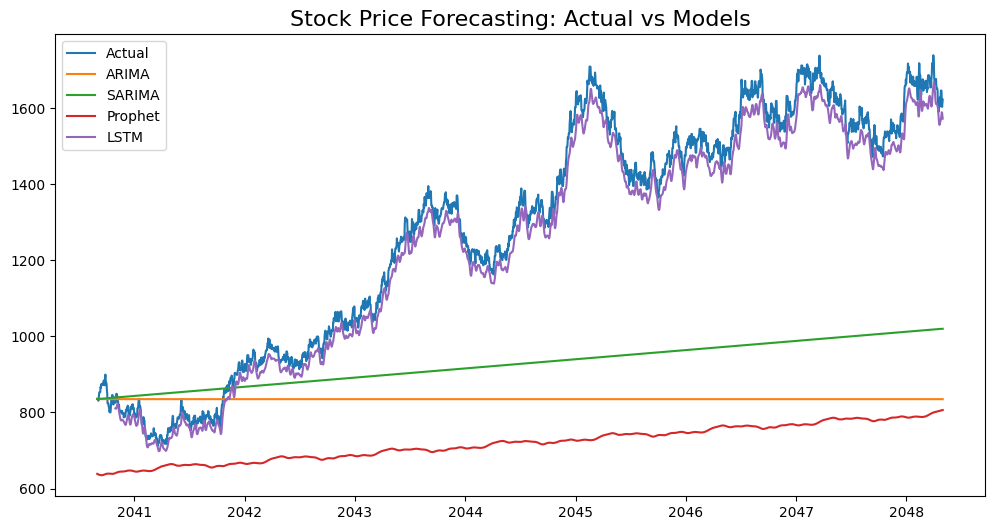

In [12]:
plt.figure(figsize=(12,6))
plt.title("Stock Price Forecasting: Actual vs Models", fontsize=16)
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, arima_forecast, label="ARIMA")
plt.plot(test.index, sarima_forecast, label="SARIMA")
plt.plot(test.index, prophet_forecast, label="Prophet")
plt.plot(test.index[-len(lstm_pred):], lstm_pred, label="LSTM")
plt.legend()
plt.show()


## Save Models & Artifacts

In [13]:
import joblib
from prophet.serialize import model_to_json

joblib.dump(arima_model, "arima_model.pkl")
joblib.dump(sarima_model, "sarima_model.pkl")
with open("prophet_model.json","w") as f:
    f.write(model_to_json(m))
lstm.save("lstm_model.h5")


## Streamlit App

2025-09-24 20:39:33.824 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 20:39:36.496 
  command:

    streamlit run C:\Users\DEL\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-24 20:39:36.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 20:39:36.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 20:39:36.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 20:39:36.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 20:39:36.703 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-24 20:39:36.705 Thread

DeltaGenerator()

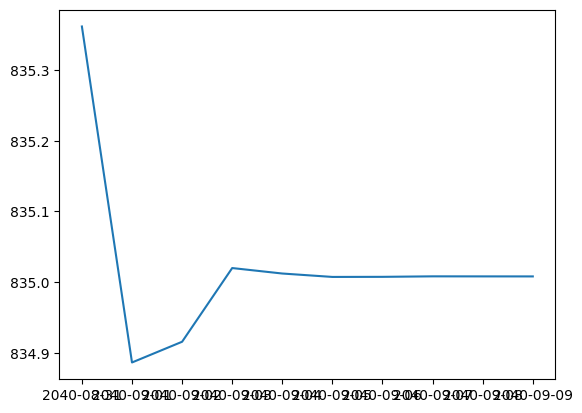

In [14]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import joblib

st.title("📈 Stock Price Forecasting")

# Load models
arima_model = joblib.load("arima_model.pkl")

# Input
future_days = st.slider("Days to forecast", 1, 60, 10)

# Forecast
forecast = arima_model.forecast(steps=future_days)

# Show
st.write("Forecasted Prices:", forecast)

plt.plot(forecast, label="Forecast")
st.pyplot(plt)
